In [16]:
import numpy as np
import crispr_assembler as ca
import matplotlib.pyplot as plt
import editdistance as ed
import os
import pickle

import tqdm


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
path = '/home/anton/BigMac/skoltech/CRISPR_research/data/environmental/'
folders = sorted(os.listdir(path))[:3]

In [18]:
folders

['c1', 'r6', 'slv1']

In [19]:
res = []

for folder in folders[:5]:
    files = os.listdir(path + folder + "/out/pairs/")
    res.append(ca.restore(path + folder + "/out/pairs/" + files[0], 5))

100%|██████████| 321/321 [00:00<00:00, 2330.61it/s]


In [20]:
files

['SlV1_GTGGCC_L001_R1_001.fastq.gz_pairs.txt',
 'SlV1_GTGGCC_L001_R2_001.fastq.gz_pairs.txt']

In [21]:
grs = [x.graph_from_pairs()[0] for x in tqdm.tqdm(res)]

100%|██████████| 3/3 [00:13<00:00,  4.39s/it]


In [22]:
cut = 150
grs_cut = [x[:cut, :cut] for x in grs]

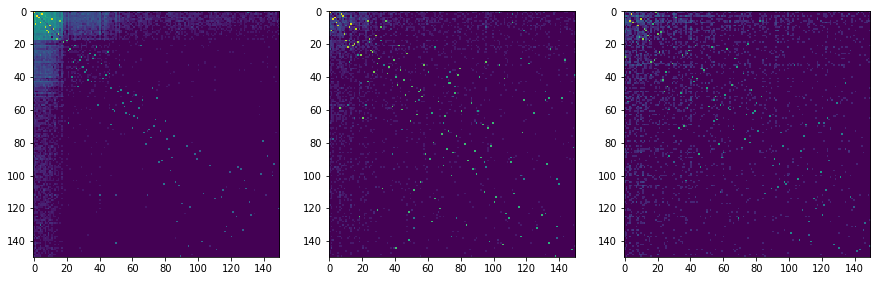

In [23]:
ca.plot_grs(*grs_cut,  log=1, s =15)

In [24]:
ec = ca.EmbeddingsCalculator()

In [25]:
embs = []
for gr in tqdm.tqdm(grs):
    ec = ca.EmbeddingsCalculator()
    embs.append(ec.fit_predict(gr))

100%|██████████| 3/3 [00:26<00:00,  8.77s/it]


In [26]:
gb = pickle.load(open("./lr_rep_to_rep", "rb"))

In [27]:
pred_grs = [gb.predict(emb).reshape(gr.shape) for emb, gr in zip(embs, grs)]

In [28]:
cut = 150
pred_grs_cut = [x[:cut, :cut] for x in pred_grs]

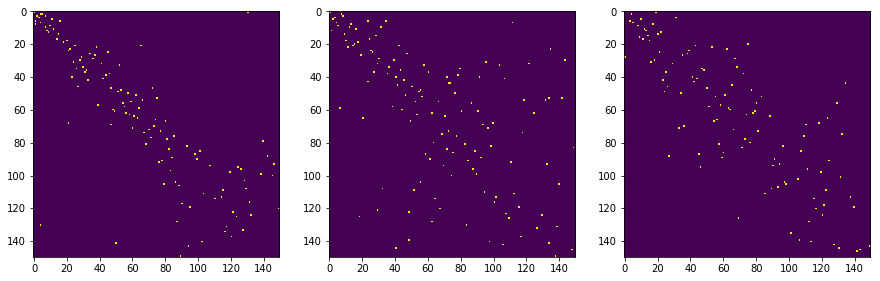

In [29]:
ca.plot_grs(*pred_grs_cut,  log=1, s =15)

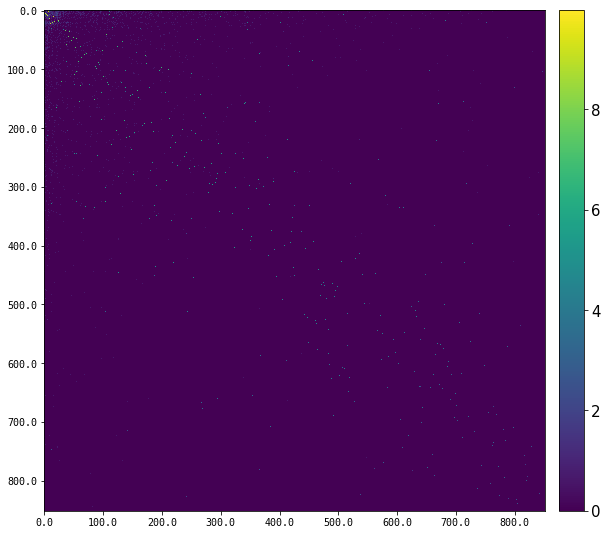

In [30]:
ca.plot_gr(grs[1],  log=1, s =15)

In [31]:
[x.shape for x in pred_grs]

[(283, 283), (852, 852), (297, 297)]

In [34]:
from importlib import reload
ca = reload(ca)

In [35]:
cut = 200
pred_grs_cut = [x[:cut, :cut] for x in pred_grs]
arrs = [[x for x in ca.restore_arrays_all(x)[1] if len(x) > 2] for x in tqdm.tqdm(pred_grs_cut)]

  0%|          | 0/3 [00:00<?, ?it/s]

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

 67%|██████▋   | 2/3 [00:00<00:00, 10.21it/s]

A Jupyter Widget

A Jupyter Widget

100%|██████████| 3/3 [00:00<00:00, 10.38it/s]

In [36]:
def sort_names(names, keys_order = ['first', 'second', 'soft', 'greedy']): 
    order = np.argsort(names)
    
    names_presorted = np.array(names)[order]
    
    new_order = []
    key_to_color = dict(zip(keys_order, ['g','g','c','y']))
    colors = []
    
    for key in keys_order:
        for name, idx in zip(names_presorted, order):
            if name.split("_")[0] == key:
                new_order.append(idx)
                colors.append(key_to_color[key])
                
                
    return np.array(new_order), colors
    

In [37]:
def create_combined_array(alignments):
    combined = []
    i, j = 0, 0
    
    while j < len(alignments[0]): 
        if alignments[i][j] != '-':
            combined.append(alignments[i][j])
            j += 1
        else:
            i += 1
            i = i % len(alignments)
    
    return combined

In [38]:
def get_links(arrs):
    max_len = max([len(x) for x in arrs])
    arrs_np = np.ones((len(arrs), max_len)).astype(int) * -1
    
    for i, a in enumerate(arrs):
        arrs_np[i][:len(a)] = np.array(a)
    
    
    #return arrs_np

    links = [[] for x in range(len(arrs))]
    for i, a in enumerate(arrs):
        for j, x in enumerate(a):
            mask = np.where(arrs_np == x)
            #print(i, j, mask)
            local_links = []
            for i1, j1 in zip(mask[0], mask[1]):
                if i1 != i or j1 != j:
                    local_links.append((i1, j1))
            links[i].append(local_links)
            
    return links, arrs_np
    

In [39]:
def align(arrs, arrs_np, links, v = 0, max_iter=50):
    new_arrs = [[] for x in range(len(arrs))]
    pointers = [[i, 0] for i in range(len(arrs))]
    lens = [len(a) for a in arrs]

    def should_continue(pointers):
        if all([pointers[i][1] == lens[i] - 1 for i in range(len(arrs))]):
            return False
        else:
            return True

    def pointer_movable(p, mask):
        return mask[p[0]]
    
    movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])

    it = 0
    while any(movable_pointers_mask) and it < max_iter:
        if v:print("-------------------------")
        curr_links = []
        movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])
        
        for p in pointers:
            if pointer_movable(p, movable_pointers_mask):
                curr_links.append(links[p[0]][p[1]])
            else:
                curr_links.append([])

        links_mask = np.array([len(l) == 0 for l in curr_links])

        if v:
            print('p', pointers)
            print('cl', curr_links)
            print('lm', links_mask)
            print('mpm', movable_pointers_mask)

        if any(np.logical_and(movable_pointers_mask, links_mask)):
            p_to_move = np.where(np.logical_and(movable_pointers_mask, links_mask))[0][0]
            p = pointers[p_to_move]

            for i in range(len(new_arrs)):
                if i == p[0]:
                    new_arrs[i].append(arrs[p[0]][p[1]])
                else:
                    new_arrs[i].append('-')

            pointers[p_to_move][1] += 1

        else:
            links_clusters = set()
            for l, p in zip(curr_links, pointers):
                l_copy = [x for x in l]
                l_copy.append(p)

                l_copy = tuple(frozenset([tuple(x) for x in l_copy]))
                if len(l_copy) > 1:
                    links_clusters.add(l_copy)

            pointers_set = set([tuple(x) for x in pointers])

            if v : 
                print('ps', pointers_set)
                print('lc', links_clusters)
        
            for s in links_clusters:
                good_set = True
                if v:print('s', s)
                for el in s:
                    #if v:print('el', el)
                    if not el in pointers_set:
                        good_set = False

                if good_set:
                    if v:print('s', s)
                    completed_arrs = []

                    for el in s:
                        if  movable_pointers_mask[el[0]]:
                            new_arrs[el[0]].append(arrs[el[0]][el[1]])
                        pointers[el[0]][1] += 1
                        completed_arrs.append(el[0])

                    for i in range(len(arrs)):
                        if not i in completed_arrs:
                            new_arrs[i].append('-')
                    break
        movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])
        if v:
            for i in range(len(arrs)):
                print(pointers[i][1], len(arrs[i]), arrs[i])
        if v:print('p', pointers)
        if v:print('mpm', movable_pointers_mask)         
        if v:print('na', new_arrs)
        it += 1
    return new_arrs

In [40]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [41]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(151)

In [42]:
def draw_array(ax, array, cmap, x0, y0, step = 0.04):
    rectangles = []
    for i, a in enumerate(array):
        if a == '-':
        #if '-' in a:
            color = 'none'
        else:
            color = 'b'#cmap(a*16 % cmap.N)
        rectangles.append(Rectangle((x0 + i * step*2, y0), step*2, step,linewidth=1,
                                    edgecolor='black',
                                    facecolor=color,
                                    alpha = 0.3))
        plt.text(x0 + i * step*2, y0, a)

    for r in rectangles:
        ax.add_patch(r)
    return rectangles #rectangles

In [43]:
def draw_array_triangles(ax, array, cmap, x0, y0, mask = None, step = 0.04, color=None):
    rectangles = []
    for i, a in enumerate(array):
        if color is None:
            if not mask is None:
                if mask[i] == 0 :
                    color = 'none'
                elif mask[i] == 1:
                    color = 'g'
                elif mask[i] == 2:
                    color = 'y'
            else:
                if a == '-':
                    color = 'none'
                else:
                    color = cmap(3)
        
        #import ipdb; ipdb.set_trace()
        if a != "-":
            rectangles.append(plt.Polygon([[x0 + i * step*2, y0],
                                           [x0 + (i + 1) * step*2, y0],
                                           [x0 + i * step*2 + step,  y0 + step *1.1]],
                                      #edgecolor='black',
                                      facecolor=color,
                                      alpha = 0.5))
        else:
            rectangles.append(Rectangle((x0 + i * step*2, y0), step*2, step,linewidth=1,
                                    edgecolor='black',
                                    facecolor='none',
                                    alpha = 0.2))
            
        plt.text(x0 + i * step*2, y0, a)

    for r in rectangles:
        ax.add_patch(r)
    return rectangles #rectangles

In [44]:
def draw_allignment(ax, seq, targets, base_key, keys, cmap, x0, y0, colors, step=0.04):
    rectangles = draw_array(ax, seq, cmap, x0, y0)
    plt.text(x0 - 10 * step, y0 , base_key)
    
    #plt.show()
    i = 0 
    for i, t in enumerate(targets[:]):
        mask = []
        for j in range(len(seq)):
            if seq[j] == t[j] and seq[j] == '-':
                mask.append(0)
            elif seq[j] == t[j]:
                mask.append(1)
            else:
                mask.append(2)


        rectangles = draw_array_triangles(ax, t, cmap, x0, y0 - (i+1) * step, mask, color = colors[i])
        plt.text(x0 - 10 * step, y0 - (i+1) * step, keys[i])
#         else:
#             rectangles = draw_array(ax, t,cmap, y0 - (i+1) * step)
    return y0 - (i+2) * step

In [45]:
res[0].index_to_cluster

{0: 'AGTATTAACTGCGGTGGCAGTGAGGCCAATAG',
 1: 'TTGTCACGAACACATAGCAACTAGGTAACCAC',
 2: 'GTTATGCAGCCTGTTTGAGCAATGAAGAAAATT',
 3: 'GGCAAAAAGGCGGCGCGTTTAAAAGAGGCATA',
 4: 'TGATCAGCGAGGACACCGGCGGCGATTTTCGT',
 5: 'TGCTGGATGAGTTTATCGAACACAGAGCGGAG',
 6: 'ATACCGCAGCAAATTACGGTTCCAGAAACGCG',
 7: 'GCAGTGGTGAGGCCGGGAAGCGCGGTTGAGTC',
 8: 'GGGGCTTTTTTATATCCGCGCCACGCTCGGCG',
 9: 'ACGCGCGTACCGGATCGCGGACAACAAATTGC',
 10: 'TTTTTTTGTCGCATCCAGCCGTATTTTTTCGC',
 11: 'TTTGCTACCCGCTCAAAACCGCCGATTCGCGT',
 12: 'TCGGCCAGCGTCCAGGCTGGCACCCGATATTC',
 13: 'AAAACCAAACTTCTCCATAAATTCCATAGCCG',
 14: 'GAAATGCTGGTGAGCGTTAATGCCGCAAACAC',
 15: 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC',
 16: 'TTCACGCCAACGCAGAGGCGGGCCGCGTTAAT',
 17: 'TGGCTCTGCAACAGCAGCACCCATGACCACGT',
 18: 'TACGTGAAGAATATTTGCAACACCCGCAAGAA',
 19: 'AACATCGGAAACGGCTTCGCGGCGGCGGCGTC',
 20: 'GGCATAGCCAGGCTGATCCGGCGACGGCCTTA',
 21: 'TCAACATTATCAATTACAACCGACAGGGAGCC',
 22: 'GTAGTCCATCATTCCACCTATGTCTGAACTCC',
 23: 'TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG',
 24: 'GCGACCGCTCAGAAATTCC

In [46]:
arrs_spacers = []

for a, r in zip(arrs, res):
    new_a = []
    for el in a: 
        new_a.append([r.index_to_cluster[x] for x in el])
    arrs_spacers.append(new_a)

In [47]:
ec = ca.ErrorCorrector(5)

In [48]:
ec.fit(ca.unwrap_nested(arrs_spacers, 2))

100%|██████████| 396/396 [00:00<00:00, 1795.70it/s]


In [49]:
arrs_corrected = []

for a in arrs_spacers:
    new_a = []
    for el in a:
        new_a.append([ec.spacer_to_cluster_index[x] for x in el])
    arrs_corrected.append(new_a)

In [50]:
keys = ['cat', 'new_slon', 'vesna_slon']

In [169]:
candidates = {}

for k, a in zip(keys[:1] + keys[2:], arrs[:1] + arrs[2:]):
    #print(a)
    for i, el in enumerate(a):
        candidates[k + "_" + str(i)] = el

In [169]:
candidates = {}

for k, a in zip(keys[:1] + keys[2:], arrs[:1] + arrs[2:]):
    #print(a)
    for i, el in enumerate(a):
        candidates[k + "_" + str(i)] = el

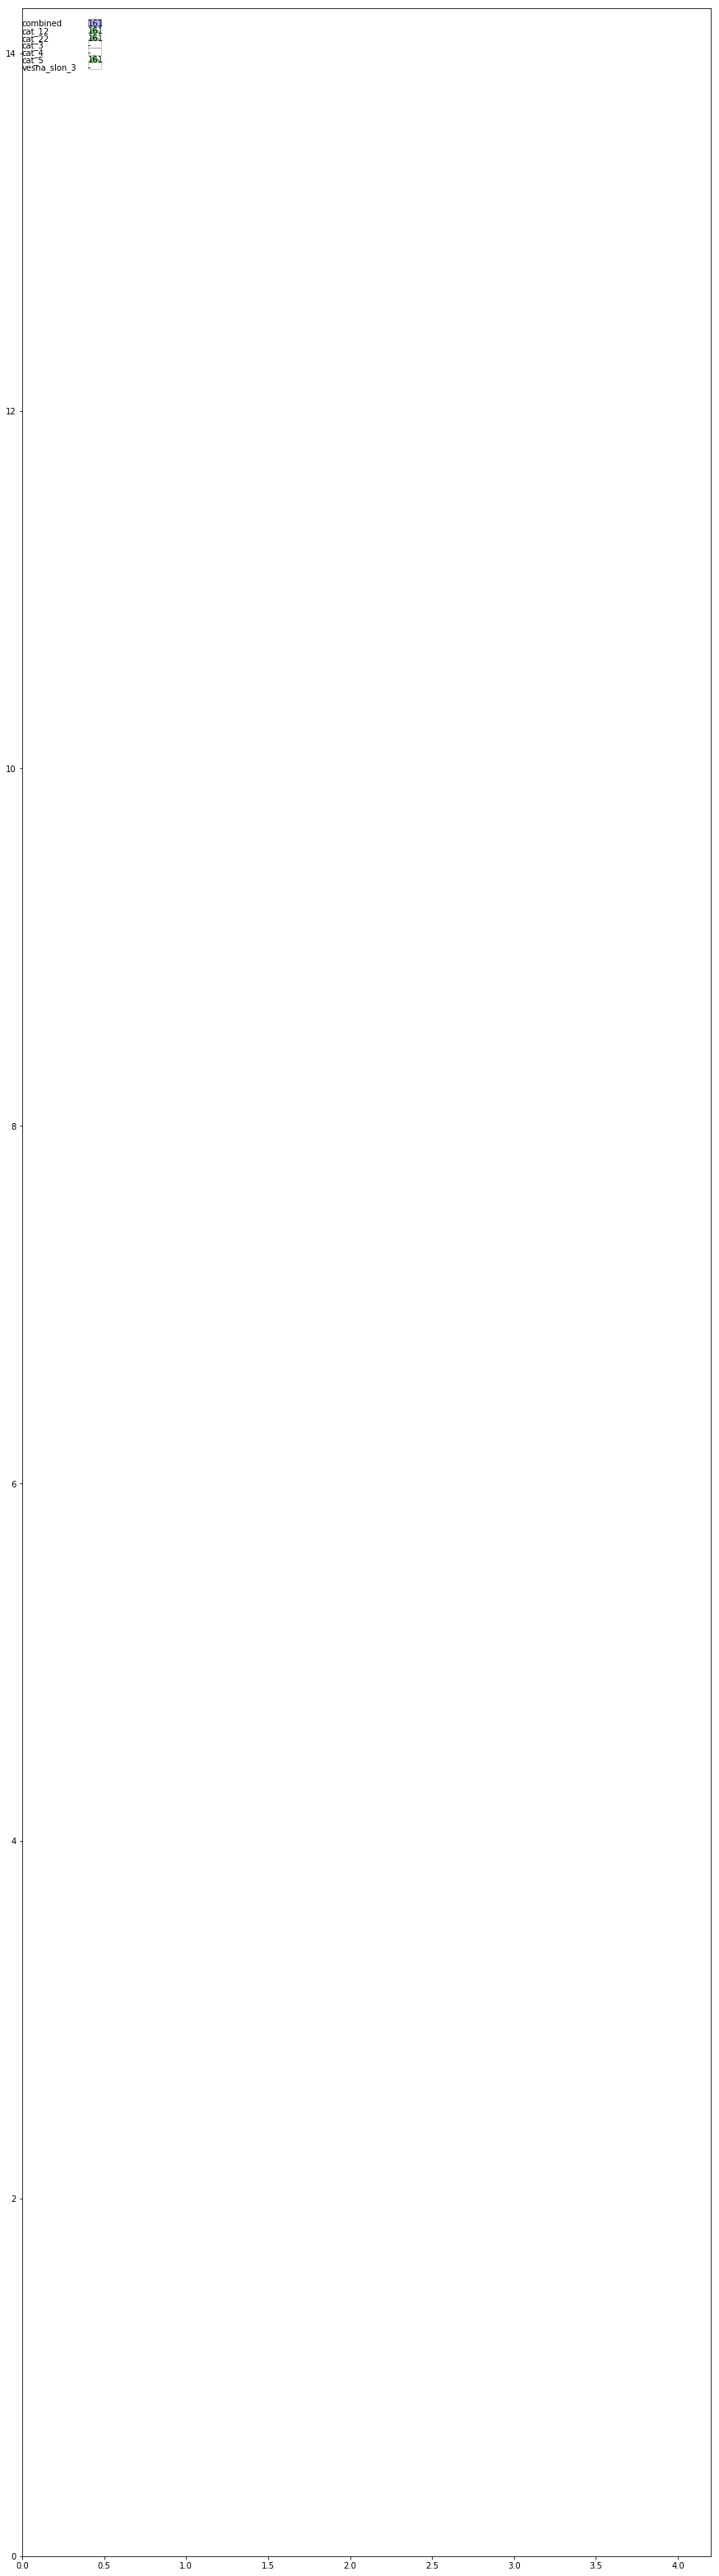

In [179]:
fig, ax = plt.subplots(1, figsize = (15,1 * len (candidates)))
ax.set_xlim(0,4.2)
ax.set_ylim(0,0.25 * len(candidates))
y0 = len(candidates) * 0.25 - 0.1


seen_keys = set()

for k,v in zip(['cat_12'], [[161, 0, 6, 1, 130, 4, 3, 7]]): #list(candidates.items())[:]:
    if not k in seen_keys:
        aligned_arrs = [v]
        aligned_keys = [k]
        curr_keys_pool = set()
        curr_keys_pool.add(k)
        search_candidates = [v]
        search = True

        #import ipdb; ipdb.set_trace() 
        max_iter = 0
        while search and max_iter < 10:
            search = False
            new_search_candidates = []
            for c in search_candidates:
                alignments = ca.water_alignments_dict(c, candidates)
                keys = sorted(list(alignments.keys()))

                for key in keys:
                    if not key in curr_keys_pool:
                        curr_keys_pool.add(key)
                        aligned_arrs.append(alignments[key][1])
                        aligned_keys.append(key)
                        search = True
                        new_search_candidates.append(candidates[key])   

            search_candidates = new_search_candidates
            max_iter += 1    

        for el in curr_keys_pool:
            seen_keys.add(el)

        #aligned_arrs_fixed = [fix_arr(el) for el in aligned_arrs]

        links, arrs_np = get_links(aligned_arrs)
        new_arrs = align(aligned_arrs, arrs_np, links)

        combined = create_combined_array(new_arrs)

        order,colors = sort_names(aligned_keys, ['cat', 'new', 'vesna'])
        new_arrs = np.array(new_arrs)
        aligned_keys = np.array(aligned_keys)


        y0 = draw_allignment(ax, combined, list(new_arrs[order]), 'combined',  aligned_keys[order], cmap, 0.4, y0, colors)
        y0 -= 0.05

#fig.savefig("../../article/pics/cluster_alignments/" + str(idx) + '.png')
# #plt.show()

#dict_keys(['second_21', 'second_65', 'second_7', 'second_9', 'restored_1', 'restored_2', 'restored_15'])

In [177]:
candidates['cat_12']

[161, 0, 6, 1, 130, 4, 3, 7]

In [180]:
aligned_arrs

[[161, 0, 6, 1, 130, 4, 3, 7],
 [161, 0, 6, 16],
 [13, 9, 10, 7, 4, 3, 2, 5, 11, 12, 8, 1, 0, 6, 16],
 [13, 9, 10, 7, 4, 3, 2, 5, 11, 12, 8, 1, 130],
 [161, 0, 6, 1, 130, 4, 3, 2, 5, 11, 12, 8],
 [2, 4, 31, 16, 9, 8, 17, 11, 12, 13, 22, 53]]

In [182]:
new_arrs

array([['161'],
       ['161'],
       ['-'],
       ['-'],
       ['161'],
       ['-']], dtype='<U21')

In [184]:
align(aligned_arrs, arrs_np, links, v =1)

-------------------------
p [[0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [5, 0]]
cl [[(1, 0), (4, 0)], [(0, 0), (4, 0)], [(3, 0), (5, 9)], [(2, 0), (5, 9)], [(0, 0), (1, 0)], [(2, 6), (3, 6), (4, 7)]]
lm [False False False False False False]
mpm [ True  True  True  True  True  True]
ps {(0, 0), (3, 0), (2, 0), (5, 0), (1, 0), (4, 0)}
lc {((3, 0), (5, 9), (2, 0)), ((3, 0), (2, 0), (5, 9)), ((5, 0), (4, 7), (2, 6), (3, 6)), ((1, 0), (0, 0), (4, 0))}
s ((3, 0), (5, 9), (2, 0))
s ((3, 0), (2, 0), (5, 9))
s ((5, 0), (4, 7), (2, 6), (3, 6))
s ((1, 0), (0, 0), (4, 0))
s ((1, 0), (0, 0), (4, 0))
1 8 [161, 0, 6, 1, 130, 4, 3, 7]
1 4 [161, 0, 6, 16]
0 15 [13, 9, 10, 7, 4, 3, 2, 5, 11, 12, 8, 1, 0, 6, 16]
0 13 [13, 9, 10, 7, 4, 3, 2, 5, 11, 12, 8, 1, 130]
1 12 [161, 0, 6, 1, 130, 4, 3, 2, 5, 11, 12, 8]
0 12 [2, 4, 31, 16, 9, 8, 17, 11, 12, 13, 22, 53]
p [[0, 1], [1, 1], [2, 0], [3, 0], [4, 1], [5, 0]]
mpm [ True  True  True  True  True  True]
na [[161], [161], ['-'], ['-'], [161], ['-']]
------------

1 4 [161, 0, 6, 16]
0 15 [13, 9, 10, 7, 4, 3, 2, 5, 11, 12, 8, 1, 0, 6, 16]
0 13 [13, 9, 10, 7, 4, 3, 2, 5, 11, 12, 8, 1, 130]
1 12 [161, 0, 6, 1, 130, 4, 3, 2, 5, 11, 12, 8]
0 12 [2, 4, 31, 16, 9, 8, 17, 11, 12, 13, 22, 53]
p [[0, 1], [1, 1], [2, 0], [3, 0], [4, 1], [5, 0]]
mpm [ True  True  True  True  True  True]
na [[161], [161], ['-'], ['-'], [161], ['-']]
-------------------------
p [[0, 1], [1, 1], [2, 0], [3, 0], [4, 1], [5, 0]]
cl [[(1, 1), (2, 12), (4, 1)], [(0, 1), (2, 12), (4, 1)], [(3, 0), (5, 9)], [(2, 0), (5, 9)], [(0, 1), (1, 1), (2, 12)], [(2, 6), (3, 6), (4, 7)]]
lm [False False False False False False]
mpm [ True  True  True  True  True  True]
ps {(0, 1), (3, 0), (2, 0), (5, 0), (4, 1), (1, 1)}
lc {((3, 0), (5, 9), (2, 0)), ((3, 0), (2, 0), (5, 9)), ((0, 1), (4, 1), (1, 1), (2, 12)), ((0, 1), (1, 1), (4, 1), (2, 12)), ((5, 0), (4, 7), (2, 6), (3, 6))}
s ((3, 0), (5, 9), (2, 0))
s ((3, 0), (2, 0), (5, 9))
s ((0, 1), (4, 1), (1, 1), (2, 12))
s ((0, 1), (1, 1), (4, 1), 

[[161], [161], ['-'], ['-'], [161], ['-']]

In [ ]:
def align(arrs, arrs_np, links, v = 0, max_iter=50):
    new_arrs = [[] for x in range(len(arrs))]
    pointers = [[i, 0] for i in range(len(arrs))]
    lens = [len(a) for a in arrs]

    def should_continue(pointers):
        if all([pointers[i][1] == lens[i] - 1 for i in range(len(arrs))]):
            return False
        else:
            return True

    def pointer_movable(p, mask):
        return mask[p[0]]
    
    movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])

    it = 0
    while any(movable_pointers_mask) and it < max_iter:
        if v:print("-------------------------")
        curr_links = []
        movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])
        
        for p in pointers:
            if pointer_movable(p, movable_pointers_mask):
                curr_links.append(links[p[0]][p[1]])
            else:
                curr_links.append([])

        links_mask = np.array([len(l) == 0 for l in curr_links])

        if v:
            print('p', pointers)
            print('cl', curr_links)
            print('lm', links_mask)
            print('mpm', movable_pointers_mask)

        if any(np.logical_and(movable_pointers_mask, links_mask)):
            p_to_move = np.where(np.logical_and(movable_pointers_mask, links_mask))[0][0]
            p = pointers[p_to_move]

            for i in range(len(new_arrs)):
                if i == p[0]:
                    new_arrs[i].append(arrs[p[0]][p[1]])
                else:
                    new_arrs[i].append('-')

            pointers[p_to_move][1] += 1

        else:
            links_clusters = set()
            for l, p in zip(curr_links, pointers):
                l_copy = [x for x in l]
                l_copy.append(p)

                l_copy = tuple(frozenset([tuple(x) for x in l_copy]))
                if len(l_copy) > 1:
                    links_clusters.add(l_copy)

            pointers_set = set([tuple(x) for x in pointers])

            if v : 
                print('ps', pointers_set)
                print('lc', links_clusters)
        
            for s in links_clusters:
                good_set = True
                if v:print('s', s)
                for el in s:
                    #if v:print('el', el)
                    if not el in pointers_set:
                        good_set = False

                if good_set:
                    if v:print('s', s)
                    completed_arrs = []

                    for el in s:
                        if  movable_pointers_mask[el[0]]:
                            new_arrs[el[0]].append(arrs[el[0]][el[1]])
                        pointers[el[0]][1] += 1
                        completed_arrs.append(el[0])

                    for i in range(len(arrs)):
                        if not i in completed_arrs:
                            new_arrs[i].append('-')
                    break
        movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])
        if v:
            for i in range(len(arrs)):
                print(pointers[i][1], len(arrs[i]), arrs[i])
        if v:print('p', pointers)
        if v:print('mpm', movable_pointers_mask)         
        if v:print('na', new_arrs)
        it += 1
    return new_arrs